# Programming Assignment 2: Sentiment analysis with SVM

In this programming assignment, we will revisit the problem of sensiment analysis, but using a different approach. Recall that the task is to predict the *sentiment* (positive or negative) of a single sentence taken from a review of a movie, restaurant, or product. The data set consists of 3000 labeled sentences, which we divide into a training set of size 2500 and a test set of size 500. Previously we found a logistic regression classifier. Today we will use a support vector machine.

Make sure the notebook is in the same folder that contains `full_set.txt`.

## 1. Load and preprocess data

In [ ]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import random
from progressbar import ProgressBar
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#Append the directory to your python path using sys

import sys
prefix = '/content/gdrive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
#customized_path_to_your_homework = 'ECE 4424  CS 4824/ProgAs1/ProgAs1_notebook_data'
customized_path_to_your_homework = 'ECE 4424  CS 4824/ProgAs2'
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). To be consistent with our notation from lecture, we will change the negative review label to '-1'.

In [ ]:
## Read in the data set.
with open("/content/gdrive/My Drive/ECE 4424  CS 4824/ProgAs2/full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

### Preprocessing the text data

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. We will do four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

We begin with first two steps.

In [ ]:
## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have put together a very small list of stop words, but these are by no means comprehensive. Feel free to use something different; for instance, larger lists can easily be found on the web.

In [ ]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. In this representation, each word is thought of as corresponding to a number in `{1, 2, ..., d}` where `d` is the size of our vocabulary. And each sentence is represented as a d-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.

To do this transformation, we will make use of the `CountVectorizer` class in `scikit-learn` (Note that this is the only time you can call an external function from scikit-learn). We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

Once we get the bag-of-words representation, append a '1' to the beginning of each vector to allow our linear classifier to learn a bias term.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)
data_mat = data_features.toarray()
print ('The original size: ',data_features.shape)
print(data_mat.shape)

The original size:  (3000, 4500)
(3000, 4500)


### Training / test split

Finally, we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [ ]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("train label: ", train_labels.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
train label:  (2500,)
test data:  (500, 4500)


## 2. Solving for soft-margin SVM


Recall that support vector machine (SVM) finds a linear decision boundary with the largest margin for a binary classification problem. Suppose we have a training dataset $\{(x_{1},y_1),...,(x_n,y_n)\}$
where $x_{i} \in \mathbb{R}^{d}$ are feature vectors and $y_i\in\{-1,+1\}$ are labels.  The linear classifier is parametrized by $\theta\in \mathbb{R}^{d}$ and $\theta_0\in\mathbb{R}$, and predicts +1 at a point $x$ if $\theta\cdot x+\theta_0>0$ and -1 otherwise. 

It turns out that the soft-margin SVM optimization is equivalent to the following unconstrained optimization:
$$\underset{\theta\in\mathbb{R}^d,\theta\in\mathbb{R}}{\text{min}}\|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{hinge}}(y_i(\theta\cdot x_i+\theta_0))$$
where  $\ell_{\mathrm{hinge}}(t)=\max(0,1-t)$ is called the ``hinge loss,'' which takes value $1-t$ if $t<1$ and 0 otherwise. For example, $\ell_{\mathrm{hinge}}(-1)=2$, and $\ell_{\mathrm{hinge}}(2)=0$. 


It turns out that for gradient-based optimization, hinge loss may be difficult to deal with because it is not differentiable at point $t=1$. One solution is to use the ``smoothed version'' of hinge loss:

$$\ell_{\mathrm{smooth-hinge}}(t) = \begin{cases}
\frac{1}{2} - t      & \text{if} ~~ t \le 0, \\
\frac{1}{2} (1 - t)^2 & \text{if} ~~ 0 < t < 1, \\
0                      & \text{if} ~~ 1 \le t
\end{cases}$$


Thus, in the rest of the problem, we will consider the following optimization:
$$\underset{\theta\in\mathbb{R}^d,\theta\in\mathbb{R}}{\text{min}}\|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{smooth-hinge}}(y_i(\theta\cdot x_i+\theta_0))$$

**Task P2:** Implement the hinge loss function and the smooth hinge loss function. Plot the function $\ell_{\mathrm{hinge}}(t)$ and $\ell_{\mathrm{smooth-hinge}}(t)$for $t\in[-5,5]$.

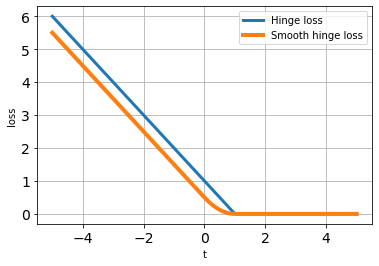

In [ ]:
def hinge_loss(t):
### STUDENT: Start of code ###
    a = np.array([0,1-t])
    loss_hinge = np.amax(a)
    return loss_hinge
### End of code ###


def hinge_loss_smooth(t):
### STUDENT: Start of code ###
    if t <= 0:
      loss_smooth_hinge = 0.5 - t
    elif t >0 and t <1:
      loss_smooth_hinge = 0.5*(1 - t)**2
    elif t>=1:
      loss_smooth_hinge = 0
    return loss_smooth_hinge
### End of code ###


#Plot
### STUDENT: Start of code ###
    
t = np.linspace(-5,5,100)
my_hinge = list()
my_smooth_hinge = list()
for u in t:
  my_val1 = hinge_loss(u)
  my_hinge.append(my_val1)
  my_val2 = hinge_loss_smooth(u)
  my_smooth_hinge.append(my_val2)

plt.plot(t,my_hinge, linewidth=3)
plt.plot(t,my_smooth_hinge, linewidth=4)
plt.xlabel('t')
plt.ylabel('loss')
plt.grid()
#plt.show()
plt.legend(["Hinge loss", "Smooth hinge loss"])
plt.show()
#print(t)

### End of code ###


**Task P5:** Let $f(\theta,\theta_0)= \|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{smooth-hinge}}(y_i(\theta\cdot x_i+\theta_0))$ be the objective function of the optimization problem we want to solve. Implement the function that obtains the partial derivative $\frac{\partial }{\partial \theta}f(\theta,\theta_0)$ and $\frac{\partial }{\partial \theta_0}f(\theta,\theta_0)$. Also, print out the output of the code that calculates the derivatives at $\theta=1$ and $\theta_0=1$ with $C=1$.

Hint: you need to calculate the partial derivative of the smoothed hinge loss for each data point separately, and add them together to obtain the result.

In [ ]:
def weight_derivative(theta, theta0, C,feature_matrix, labels):
    # Input:
    # theta: weight vector theta, a numpy vector of dimension d
    # theta0: intercept theta0, a numpy vector of dimension 1
    # C: constant C
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d, each with value -1 or +1
    # Output:
    # Derivative of the cost function with respect to the weight theta, grad_theta
    # Derivative of the cost function with respect to the weight theta0, grad_theta0
        
    ## STUDENT: Start of code ###
    sz = feature_matrix.shape
    grad_mx = np.zeros((sz[0],sz[1]))
    grad_mx0 = np.zeros((sz[0]))
    ss = theta0.shape
    
    for j in range(sz[0]):
      # if ss[0] > 1:
      t = labels[j]*(np.dot(theta,feature_matrix[j][:]) + theta0[0])
      if t <= 0:
        der_theta = ( (-1)*labels[j]*feature_matrix[j][:])
        der_theta0 = (-1)* labels[j]
        #print("if 1 iteration", j)
      elif t >0 and t <1:
        der_theta = (-1)*labels[j]*feature_matrix[j][:]*(1-(labels[j]*(np.dot(theta,feature_matrix[j][:]) + theta0[0]))) #(-(1-t)*feature_matrix[j][:])
        der_theta0 = (-1)*labels[j]*(1-(labels[j]*(np.dot(theta,feature_matrix[j][:]) + theta0[0])))
        #print("if 2 iteration", j)
      elif t>=1:
        der_theta = np.zeros(sz[1])
        der_theta0 = 0
        #print("if 3 iteration", j)
      # elif bool(ss):
      #   t = labels[j]*(np.dot(theta,feature_matrix[j][:]) + theta0)
      #   if t <= 0:
      #     der_theta = ( - labels[j]*feature_matrix[j][:])
      #     der_theta0 = - labels[j]
      #   elif t >0 and t <1:
      #     der_theta = (-t*feature_matrix[j][:])
      #     der_theta0 = -(1-(labels[j]*(np.dot(theta,feature_matrix[j][:]) + theta0[j])))*labels[j]
      #   elif t>=1:
      #     der_theta = 0
      #     der_theta0 = 0
      grad_mx[j][:] = der_theta
      grad_mx0[j] = der_theta0

    grad_theta = 2*theta + C*grad_mx.sum(axis=0)
    grad_theta0 =  C*grad_mx0.sum(axis=0)
   
    return grad_theta, grad_theta0
    # End of code ###

In [ ]:
# STUDENT: PRINT THE OUTPUT AND COPY IT TO THE SOLUTION FILE
theta = np.ones(data_mat.shape[1]) # a weight of all 1s
theta0 = np.ones(1) # a number 1
C = 1
grad_theta, grad_theta0 = weight_derivative(theta, theta0, C,train_data,train_labels)

print (grad_theta[:10])
print (grad_theta0)


[ 2.  3.  3.  4.  3.  3. 38.  5.  2.  2.]
1250.0


**Task P6:**  For sentiment analysis data, choose a value for the trade-off parameter $C$. Report the training error at convergence and the testing error. 

Note:  you can just use the same gradient descent algorithm that we wrote in assignment 2, or use the adam_optimizer provided below.

Here is an [article](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c#:~:text=Adam%20%5B1%5D%20is%20an%20adaptive,for%20training%20deep%20neural%20networks.&text=The%20algorithms%20leverages%20the,learning%20rates%20for%20each%20parameter) on the Adam optimizer.

In [ ]:
def objective(feature_matrix, labels, theta,theta0, C):
    score = (feature_matrix.dot(theta)+theta0)*labels
    return np.sum(theta**2)+C*np.sum([hinge_loss_smooth(t) for t in score])

In [ ]:
def adam_optimizer(feature_matrix, labels, initial_theta,initial_theta0, C, step_size=0.01, tolerance=0.01, b1=0.9, b2=0.999, eps=10**-8):
    # Gradient descent algorithm for logistic regression problem    
    
    # Input:
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # initial_theta: initial theta to start with, a numpy vector of dimension d
    # initial_theta0: initial theta0 to start with, a numpy vector of dimension 1
    # step_size: step size of update
    # tolerance: tolerace epsilon for stopping condition
    # Parameters by Adam optimizer
    # Output:
    # Weights obtained after convergence

    converged = False 
    m = np.zeros(len(initial_theta))
    v = np.zeros(len(initial_theta))
    m0 = np.zeros(1)
    v0 = np.zeros(1)
    theta = np.array(initial_theta) # current iterate
    theta0 = np.array(initial_theta0) # current iterate
    i = 0
    j=0
    while not converged:
    #while j< 10000:
        # impelementation of what the gradient descent algorithm does in every iteration
        # Refer back to the update rule listed above: update the weight
        i += 1
        j=i
        grad_theta, grad_theta0  = weight_derivative(theta, theta0, C,feature_matrix, labels)
        
        m = (1 - b1) * grad_theta      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (grad_theta**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        theta = theta - step_size*mhat/(np.sqrt(vhat) + eps)
        
        m0 = (1 - b1) * grad_theta0      + b1 * m0  # First  moment estimate.
        v0 = (1 - b2) * (grad_theta0**2) + b2 * v0  # Second moment estimate.
        mhat0 = m0 / (1 - b1**(i + 1))    # Bias correction.
        vhat0 = v0 / (1 - b2**(i + 1))
        theta0 = theta0 - step_size*mhat0/(np.sqrt(vhat0) + eps)
        
        # Compute the gradient magnitude:
        
        gradient_magnitude = np.sqrt(np.sum(grad_theta**2))
        
        # Check the stopping condition to decide whether you want to stop the iterations
        
        if gradient_magnitude < tolerance:
            converged = True
        
        preds_train = model_predict(train_data,theta,theta0)

        ## Compute errors
        errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))

        print ("Iteration: ",i,"objective: ",objective(feature_matrix, labels, theta,theta0, C),"tr err: ",float(errs_train)/len(train_labels),"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        
    return(theta, theta0)

### End of code ###

In [ ]:
def model_predict(feature_matrix,theta,theta0):
# Prediction made by SVM 
    
    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # theta: weight theta, a numpy vector of dimension d
    # theta0: weight theta0, a numpy vector of dimension 1
    # Output:
    # labels: predicted labels, a numpy vector of dimension n
    
    h =  feature_matrix.dot(theta)+theta0
    y_h = (h >= 0)*2-1
    
    return y_h    

In [ ]:
# Initialize the weights, step size and tolerance
# Start of code
initial_theta =  np.random.rand(feature_matrix.shape[1])## STUDENT: initialize theta
initial_theta0 =  np.random.rand(1) #np.ones(feature_matrix.shape[0]) ## STUDENT: initialize theta0
C = 1 ## STUDENT: choose the C
step_size = 0.25 ## STUDENT: choose the step_size
tolerance = 0.01 ## STUDENT: choose the tolerance

# end of code

theta, theta0 = adam_optimizer(train_data,train_labels, initial_theta, initial_theta0,C, step_size, tolerance)
print(theta)
print(theta0)

Iteration:  1 objective:  5744.056138901959 tr err:  0.5 gradient_magnitude:  861.0433400306346
Iteration:  2 objective:  2603.860324555173 tr err:  0.474 gradient_magnitude:  853.4614786482572
Iteration:  3 objective:  2003.1389415438102 tr err:  0.4236 gradient_magnitude:  719.6627883714607
Iteration:  4 objective:  2757.1400803195693 tr err:  0.4268 gradient_magnitude:  714.4866332583961
Iteration:  5 objective:  2764.0214714500753 tr err:  0.3976 gradient_magnitude:  911.7033810979287
Iteration:  6 objective:  2223.8326375749402 tr err:  0.3096 gradient_magnitude:  907.1923931148376
Iteration:  7 objective:  1587.5785524393732 tr err:  0.1784 gradient_magnitude:  801.808856977141
Iteration:  8 objective:  1252.3047802101464 tr err:  0.088 gradient_magnitude:  499.5090209663632
Iteration:  9 objective:  1219.1653894564452 tr err:  0.0648 gradient_magnitude:  202.3249562156505
Iteration:  10 objective:  1335.961543854242 tr err:  0.1008 gradient_magnitude:  119.69773744861357
Iterati

In [ ]:
# STUDENT: copy the output of this section to the solution file

## Get predictions on training and test data
preds_train = model_predict(train_data,theta,theta0)
preds_test = model_predict(test_data,theta,theta0)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print ("Training error: ", float(errs_train)/len(train_labels))
print ("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.012
Test error:  0.144


**Task P7:** List 4 example sentences that are correctly classified by SVM, and 4 example sentences that are  incorrectly classified by SVM. Explain what you have found.

**Findings and Observations** : Here we compare the test labels given to us with the lasbels that we have predicted using our SVM classisfication algorithm. Firstly we observe first four sentences that are correctly classified followed by four sentences that are misclassified.
Firstly we observe that most of the misclassified text are relatively longer than the correctly classified text. Thus it was diffivult for the SVM classifier to label longer sentences. It is not possible to understand distict postive or negetive sentiments from the misclassified sentences. Thus we can conclude the the texts with ambigous sentences will be difficult for classifiaction by SVM. Overall the SVM has acceptable performance.

In [ ]:
score = (test_data.dot(theta)+theta0)*test_labels
predv = (test_data.dot(theta)+theta0)
inds = np.nonzero(score>1)[0]
print("Sentences correctly classified:")
for i in inds[:4]:
    ind = np.array(test_inds)[i]
    print('Label: ',test_labels[i],'; ', 'Pred label: ',(predv[i]>0)*2-1,'; ',sentences[ind])

Sentences correctly classified:
Label:  -1 ;  Pred label:  -1 ;  I cannot make calls at certain places.
Label:  -1 ;  Pred label:  -1 ;  All in all its an insult to one's intelligence and a huge waste of money.  
Label:  -1 ;  Pred label:  -1 ;  The plot is nonsense that doesn't interest in the slightest way or have any uniqueness to it.  
Label:  -1 ;  Pred label:  -1 ;  bad fit, way too big.


In [ ]:
score = (test_data.dot(theta)+theta0)*test_labels
predv = (test_data.dot(theta)+theta0)
inds = np.nonzero(score<-1)[0]
print("Sentences incorrectly classified:")
for i in inds[:4]:
    ind = np.array(test_inds)[i]
    print('Label: ',test_labels[i],'; ', 'Pred label: ',(predv[i]>0)*2-1,'; ',sentences[ind])

Sentences incorrectly classified:
Label:  -1 ;  Pred label:  1 ;  Coming here is like experiencing an underwhelming relationship where both parties can't wait for the other person to ask to break up.
Label:  -1 ;  Pred label:  1 ;  If you do go see this movie, bring a pillow or a girlfriend/boyfriend to keep you occupied through out.  
Label:  -1 ;  Pred label:  1 ;  Full of unconvincing cardboard characters it is blandly written by Edward Chodorov, who also produced, and is surprisingly directed by Jean Negulesco from whom one would expect a great deal more.  
Label:  -1 ;  Pred label:  1 ;  You need two hands to operate the screen.This software interface is decade old and cannot compete with new software designs.
